# **Cycling analysis**

---

## **Imports**

In [2]:
import requests
from bs4 import BeautifulSoup
import os
import re
from urllib.parse import urljoin
import selenium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
%matplotlib inline

---

## **Import csv files**

### **Inspect differences between CSV files**

In [3]:
# Define data folder
data_folder = "data/tfl_cycling_data"

# Get all CSV files
csv_files = sorted([f for f in os.listdir(data_folder) if f.endswith(".csv")])

# Dictionary to store column names for each file
column_map = {}

# Extract column names from each CSV file
for file in csv_files:
    df = pd.read_csv(os.path.join(data_folder, file), nrows=1)  # Read only first row for efficiency
    column_map[file] = set(df.columns)

# Find unique sets of column names
unique_column_sets = {}
for file, columns in column_map.items():
    columns_tuple = tuple(sorted(columns))  # Convert to tuple for dict keys (hashable)
    if columns_tuple not in unique_column_sets:
        unique_column_sets[columns_tuple] = []
    unique_column_sets[columns_tuple].append(file)

# Print summary of differences
for idx, (columns, files) in enumerate(unique_column_sets.items()):
    print(f"🔹 **Column Set {idx+1}: Found in {len(files)} files**")
    print(f"Files: {files[:5]}{'...' if len(files) > 5 else ''}")  # Show first few files
    print(f"Columns: {columns}\n")

🔹 **Column Set 1: Found in 89 files**
Files: ['246JourneyDataExtract23Dec2020-29Dec2020.csv', '246JourneyDataExtract30Dec2020-05Jan2021.csv', '247JourneyDataExtract06Jan2021-12Jan2021.csv', '248JourneyDataExtract13Jan2021-19Jan2021.csv', '249JourneyDataExtract20Jan2021-26Jan2021.csv']...
Columns: ('Bike Id', 'Duration', 'End Date', 'EndStation Id', 'EndStation Name', 'Rental Id', 'Start Date', 'StartStation Id', 'StartStation Name')

🔹 **Column Set 2: Found in 1 files**
Files: ['325JourneyDataExtract06Jul2022-12Jul2022.csv']
Columns: ('Bike Id', 'Duration', 'End Date', 'EndStation Name', 'Rental Id', 'Start Date', 'StartStation Id', 'StartStation Name')

🔹 **Column Set 3: Found in 53 files**
Files: ['335JourneyDataExtract12Sep2022-18Sep2022.csv', '336JourneyDataExtract19Sep2022-25Sep2022.csv', '337JourneyDataExtract26Sep2022-02Oct2022.csv', '338JourneyDataExtract03Oct2022-09Oct2022.csv', '339JourneyDataExtract10Oct2022-16Oct2022.csv']...
Columns: ('Bike model', 'Bike number', 'End date

### **Group similar files**

In [4]:
file_groups = {}

for idx, (columns, files) in enumerate(unique_column_sets.items()):
    var_name = f"group_{idx+1}"
    file_groups[var_name] =  files

# Access groups
group_1 = file_groups.get("group_1", [])
group_2 = file_groups.get("group_2", [])
group_3 = file_groups.get("group_3", [])

# Print to verify
print("Group 1 files:", group_1[:5])
print("Group 2 files:", group_2[:5])
print("Group 3 files:", group_3[:5])

Group 1 files: ['246JourneyDataExtract23Dec2020-29Dec2020.csv', '246JourneyDataExtract30Dec2020-05Jan2021.csv', '247JourneyDataExtract06Jan2021-12Jan2021.csv', '248JourneyDataExtract13Jan2021-19Jan2021.csv', '249JourneyDataExtract20Jan2021-26Jan2021.csv']
Group 2 files: ['325JourneyDataExtract06Jul2022-12Jul2022.csv']
Group 3 files: ['335JourneyDataExtract12Sep2022-18Sep2022.csv', '336JourneyDataExtract19Sep2022-25Sep2022.csv', '337JourneyDataExtract26Sep2022-02Oct2022.csv', '338JourneyDataExtract03Oct2022-09Oct2022.csv', '339JourneyDataExtract10Oct2022-16Oct2022.csv']


### **Separate unique files into separate Data Frames**

In [5]:
data_folder = "data/tfl_cycling_data"

df1_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_1]
df1 =  pd.concat(df1_batch, ignore_index=True)

df2_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_2]
df2 =  pd.concat(df2_batch, ignore_index=True)

df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]
df3 =  pd.concat(df3_batch, ignore_index=True)

/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_9704/993685103.py:9: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]
/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_9704/993685103.py:9: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]
/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_9704/993685103.py:9: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df3_batch = [pd.read_csv(os.path.join(data_folder, file)) for file in group_3]


---

## **Rename columns**

#### **Comparison**  
- "Rental Id" -> "Number";  
- "Duration" (seconds) -> "Total duration (ms)" -------> delete column "Total duration";  
- "Bike Id" -> "Bike number";  
- "End Date" -> "End date";  
- "EndStation Id" -> "End station number";  
- "EndStation Name" -> "End station";  
- "Start Date" -> "Start date";  
- "StartStation Id" -> "Start station number";  
- "StartStation Name" -> "Start station";  

Only in second dataset:  
- "Bike model"
- "Total duration"

In [6]:
list(df1.columns)

['Rental Id',
 'Duration',
 'Bike Id',
 'End Date',
 'EndStation Id',
 'EndStation Name',
 'Start Date',
 'StartStation Id',
 'StartStation Name']

In [7]:
new_col_names_df1 = {
    'Rental Id': "rental_id",
    'Duration': "duration",
    'Bike Id': "bike_id",
    'End Date': "end_date",
    'EndStation Id': "end_station_id",
    'EndStation Name' :"end_station_name",
    'Start Date': "start_date",
    'StartStation Id': "start_station_id",
    'StartStation Name': "start_station_name"
}

In [8]:
df1 = df1.rename(columns=new_col_names_df1)
df1.head()

,rental_id,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name
0,104666386,5100,17552,24/12/2020 18:19,107,"Finsbury Leisure Centre, St. Luke's",24/12/2020 16:54,30,"Windsor Terrace, Hoxton"
1,104708347,2400,12134,27/12/2020 14:37,194,"Hop Exchange, The Borough",27/12/2020 13:57,298,"Curlew Street, Shad Thames"
2,104664061,300,18429,24/12/2020 15:23,91,"Walnut Tree Walk, Vauxhall",24/12/2020 15:18,272,"Baylis Road, Waterloo"
3,104723992,1440,17175,28/12/2020 13:30,742,"Blenheim Crescent, Ladbroke Grove",28/12/2020 13:06,303,"Albert Gate, Hyde Park"
4,104721666,840,15313,28/12/2020 11:23,307,"Black Lion Gate, Kensington Gardens",28/12/2020 11:09,742,"Blenheim Crescent, Ladbroke Grove"


In [9]:
# Convert 'start_date' and 'end_date' to datetime
df1['start_date'] = pd.to_datetime(df1['start_date'], errors='coerce')
df1['end_date'] = pd.to_datetime(df1['end_date'], errors='coerce')

/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_9704/798039224.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1['start_date'] = pd.to_datetime(df1['start_date'], errors='coerce')
/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_9704/798039224.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1['end_date'] = pd.to_datetime(df1['end_date'], errors='coerce')


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19517751 entries, 0 to 19517750
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rental_id           int64         
 1   duration            int64         
 2   bike_id             int64         
 3   end_date            datetime64[ns]
 4   end_station_id      int64         
 5   end_station_name    object        
 6   start_date          datetime64[ns]
 7   start_station_id    int64         
 8   start_station_name  object        
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 1.3+ GB


In [11]:
list(df2.columns)

['Rental Id',
 'Duration',
 'Bike Id',
 'End Date',
 'EndStation Name',
 'Start Date',
 'StartStation Id',
 'StartStation Name']

In [12]:
# does not have EndStation Id

new_col_names_df2 = {
    'Rental Id': "rental_id",
    'Duration': "duration",
    'Bike Id': "bike_id",
    'End Date': "end_date",
    'EndStation Name' :"end_station_name",
    'Start Date': "start_date",
    'StartStation Id': "start_station_id",
    'StartStation Name': "start_station_name"
}

In [13]:
df2 = df2.rename(columns=new_col_names_df2)
df2.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_id,start_station_name
0,122342973,180,16835,06/07/2022 15:26,"St. Mary & St. Michael Church, Stepney",06/07/2022 15:23,500,"Ansell House, Stepney"
1,122443043,1380,8260,08/07/2022 18:09,"Belgrove Street , King's Cross",08/07/2022 17:46,297,"Geraldine Street, Elephant & Castle"
2,122392666,600,17431,07/07/2022 17:00,"Eel Brook Common, Walham Green",07/07/2022 16:50,615,"Finlay Street, Fulham"
3,122516692,900,39,10/07/2022 11:47,"Drury Lane, Covent Garden",10/07/2022 11:32,310,"Black Prince Road, Vauxhall"
4,122561553,1140,6484,11/07/2022 09:55,"Duke Street Hill, London Bridge",11/07/2022 09:36,310,"Black Prince Road, Vauxhall"


In [14]:
# Convert 'start_date' and 'end_date' to datetime
df2['start_date'] = pd.to_datetime(df2['start_date'], errors='coerce')
df2['end_date'] = pd.to_datetime(df2['end_date'], errors='coerce')

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312144 entries, 0 to 312143
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   rental_id           312144 non-null  int64         
 1   duration            312144 non-null  int64         
 2   bike_id             312144 non-null  int64         
 3   end_date            312144 non-null  datetime64[ns]
 4   end_station_name    312144 non-null  object        
 5   start_date          312144 non-null  datetime64[ns]
 6   start_station_id    312144 non-null  int64         
 7   start_station_name  312144 non-null  object        
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 19.1+ MB


In [16]:
list(df3.columns)

['Number',
 'Start date',
 'Start station number',
 'Start station',
 'End date',
 'End station number',
 'End station',
 'Bike number',
 'Bike model',
 'Total duration',
 'Total duration (ms)']

In [17]:
df3['duration'] = df3['Total duration (ms)'] / 1000
df3.duration.head()

0    7934.133
1     736.233
2     929.662
3    1411.818
4    1400.619
Name: duration, dtype: float64

In [18]:
new_col_names_df3 = {
    'Number': "rental_id",
    'duration': "duration",
    'Bike number': "bike_id",
    'End date': "end_date",
    'End station number': "end_station_id",
    'End station' :"end_station_name",
    'Start date': "start_date",
    'Start station number': "start_station_id",
    'Start station': "start_station_name",
    "Bike model": "model",
    'Total duration': "total_duration",
    'Total duration (ms)': "total_duration_ms"
}

In [19]:
df3 = df3.rename(columns=new_col_names_df3)
df3.head()

,rental_id,start_date,start_station_id,start_station_name,end_date,end_station_id,end_station_name,bike_id,model,total_duration,total_duration_ms,duration
0,125230172,2022-09-18 23:59,001059,"Albert Embankment, Vauxhall",2022-09-19 02:11,200222,"Danvers Street, West Chelsea",54170,CLASSIC,2h 12m 14s,7934133,7934.133
1,125230173,2022-09-18 23:59,002660,"Frith Street, Soho",2022-09-19 00:11,001194,"Westminster University, Marylebone",50087,CLASSIC,12m 16s,736233,736.233
2,125230174,2022-09-18 23:59,001183,"Bramham Gardens, Earl's Court",2022-09-19 00:14,300019,"Felsham Road, Putney",54561,CLASSIC,15m 29s,929662,929.662
3,125230175,2022-09-18 23:59,010624,"Strata, Elephant & Castle",2022-09-19 00:23,300252,"Canada Water Station, Rotherhithe",54324,CLASSIC,23m 31s,1411818,1411.818
4,125230176,2022-09-18 23:59,010624,"Strata, Elephant & Castle",2022-09-19 00:23,300252,"Canada Water Station, Rotherhithe",22065,CLASSIC,23m 20s,1400619,1400.619


In [20]:
# Convert 'start_date' and 'end_date' to datetime
df3['start_date'] = pd.to_datetime(df3['start_date'], errors='coerce')
df3['end_date'] = pd.to_datetime(df3['end_date'], errors='coerce')

In [21]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11059475 entries, 0 to 11059474
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rental_id           int64         
 1   start_date          datetime64[ns]
 2   start_station_id    object        
 3   start_station_name  object        
 4   end_date            datetime64[ns]
 5   end_station_id      object        
 6   end_station_name    object        
 7   bike_id             int64         
 8   model               object        
 9   total_duration      object        
 10  total_duration_ms   int64         
 11  duration            float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 1012.5+ MB


---

### **Drop columns + store Data Frame with bike model for later use**

In [22]:
df_with_model = df3.drop(columns=["total_duration_ms", "total_duration"], axis=1)

In [23]:
# check distribution amongst bike models
df_with_model.model.value_counts(normalize=True)

model
CLASSIC       0.932367
PBSC_EBIKE    0.067633
Name: proportion, dtype: float64

In [24]:
# df3 excluding model feature to be used going forward
df3 = df_with_model.drop(columns=["model"], axis=1)

---

## **Drop ID columns as they are inconsistent in df3**

We will create our own IDs later on

In [25]:
# drop start_station_id
# drop end_station_id

df1 = df1.drop(columns=["start_station_id", "end_station_id"], axis=1)
df2 = df2.drop(columns=["start_station_id"], axis=1) # df2 never had an end_station_id to begin with
df3 = df3.drop(columns=["start_station_id", "end_station_id"], axis=1)

In [26]:
# Check columns are consistent
print(sorted(df1.columns) == sorted(df2.columns))
print(sorted(df1.columns) == sorted(df3.columns))

True
True


---

## **Concatenate Data Frames**

In [27]:
# Match df2 and df3 to the column order of df1
df2 = df2[df1.columns]
df3 =  df3[df1.columns]

# Concatenate data frames
df_combined = pd.concat([df1,df2,df3], ignore_index=True)
df_combined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name
0,104666386,5100.0,17552,2020-12-24 18:19:00,"Finsbury Leisure Centre, St. Luke's",2020-12-24 16:54:00,"Windsor Terrace, Hoxton"
1,104708347,2400.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames"
2,104664061,300.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo"
3,104723992,1440.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park"
4,104721666,840.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove"


---

## **Create new IDs**

Create new <code>start_station_id</code> based on <code>start_station_name</code>.  
Create new <code>end_station_id</code> based on <code>end_station_name</code>.  

In [28]:
# Find unique list of all station names
all_station_names = pd.concat([df_combined['start_station_name'], df_combined['end_station_name']]).unique()

# Map the stations
station_mapping = {name: idx for idx, name in enumerate(all_station_names, start=1)}

# Map the station names to their corresponding IDs
df_combined['start_station_id'] = df_combined['start_station_name'].map(station_mapping)
df_combined['end_station_id'] = df_combined['end_station_name'].map(station_mapping)

print(df_combined.head())

# Check for missing values in new IDs
print(df_combined[['start_station_id', 'end_station_id']].isnull().sum())

   rental_id  duration  bike_id            end_date  \
0  104666386    5100.0    17552 2020-12-24 18:19:00   
1  104708347    2400.0    12134 2020-12-27 14:37:00   
2  104664061     300.0    18429 2020-12-24 15:23:00   
3  104723992    1440.0    17175 2020-12-28 13:30:00   
4  104721666     840.0    15313 2020-12-28 11:23:00   

                      end_station_name          start_date  \
0  Finsbury Leisure Centre, St. Luke's 2020-12-24 16:54:00   
1            Hop Exchange, The Borough 2020-12-27 13:57:00   
2           Walnut Tree Walk, Vauxhall 2020-12-24 15:18:00   
3    Blenheim Crescent, Ladbroke Grove 2020-12-28 13:06:00   
4  Black Lion Gate, Kensington Gardens 2020-12-28 11:09:00   

                  start_station_name  start_station_id  end_station_id  
0            Windsor Terrace, Hoxton                 1             397  
1         Curlew Street, Shad Thames                 2             306  
2              Baylis Road, Waterloo                 3             372  
3   

In [29]:
df_combined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name,start_station_id,end_station_id
0,104666386,5100.0,17552,2020-12-24 18:19:00,"Finsbury Leisure Centre, St. Luke's",2020-12-24 16:54:00,"Windsor Terrace, Hoxton",1,397
1,104708347,2400.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames",2,306
2,104664061,300.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo",3,372
3,104723992,1440.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park",4,5
4,104721666,840.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove",5,435


---

## **Convert duration to minutes from seconds for readability**

In [30]:
df_combined['duration'] = df_combined['duration'] / 60

---

# **EDA**

In [31]:
df_combined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name,start_station_id,end_station_id
0,104666386,85.0,17552,2020-12-24 18:19:00,"Finsbury Leisure Centre, St. Luke's",2020-12-24 16:54:00,"Windsor Terrace, Hoxton",1,397
1,104708347,40.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames",2,306
2,104664061,5.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo",3,372
3,104723992,24.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park",4,5
4,104721666,14.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove",5,435


## **Overview**

In [32]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30889370 entries, 0 to 30889369
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rental_id           int64         
 1   duration            float64       
 2   bike_id             int64         
 3   end_date            datetime64[ns]
 4   end_station_name    object        
 5   start_date          datetime64[ns]
 6   start_station_name  object        
 7   start_station_id    int64         
 8   end_station_id      int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 2.1+ GB


In [33]:
# check for missing values
df_combined.isnull().sum()

rental_id             0
duration              0
bike_id               0
end_date              0
end_station_name      0
start_date            0
start_station_name    0
start_station_id      0
end_station_id        0
dtype: int64

In [34]:
# drop duplicates
df_combined.drop_duplicates(inplace=True)

---

## **Check for Outliers**

- The business problem is to help a client understand short-term rental-cycle usage patterns.  
- We want to avoid analysing/modelling data that does not reflect realistic user behaviour, which could skew the analysis and mislead insights.  
- We will therefore exclude extreme rental durations because they likely represent anomalies, errors, or usage patterns outside of the intended usage of these bikes.  

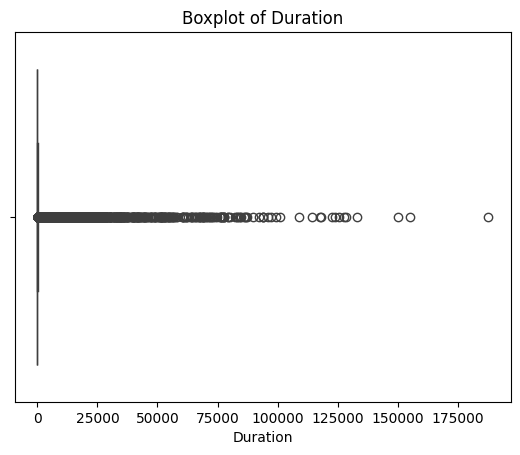

In [35]:
# Boxplot for duration
sns.boxplot(x=df_combined['duration'])

plt.title('Boxplot of Duration')
plt.xlabel('Duration')

# Show the plot
plt.show()

**Insight**:  
- For perspective - 25,000 minutes translates into 17 days. This is abnormal user behaviour.  
- 175,000 minutes is ~121 days. It is highly unlikely that a user rented a bicycle for over four months without returning it.  
- This could be due to data entry errors, unreturned bikes, system failures, or misreported timestamps.  
- The client is considering a short-term rental model, so focusing on realistic trip durations (e.g., minutes to a few hours) is more aligned with their interests.  
- Retaining extreme values could distort average trip durations, demand forecasting, and pricing models.  
- The client needs insights into bike availability, peak usage times, and station balancing. Including these extreme values could lead to misleading supply-chain insights, making it seem like some bikes were unavailable for months when they may have been lost or incorrectly logged.

### **Approach to Handling Outliers**

- Exclude bike rentals with durations exceeding 24 hours, as they likely represent system errors, missing returns, or anomalies.  
- Given that the client is focused on short-term rentals, these extreme values do not provide actionable insights into real-world usage patterns.

In [36]:
def filter_data(data, duration):
    df_filtered = data[data['duration'] <= duration]
    filtered_out_data = data.shape[0] - df_filtered.shape[0]
    filtered_out_data_percent = (filtered_out_data / data.shape[0]) * 100
    
    print(f"{filtered_out_data} records were filtered out.")
    print(f"This represents {filtered_out_data_percent:.2f}% of the data.")
    
    return df_filtered

In [37]:
# Assign a threshhold of 2 standard deviations away from the mean to assess reasonability 
mean_duration = df_combined['duration'].mean()
std_duration = df_combined['duration'].std()
threshold = mean_duration + 2 * std_duration
print(f"Mean cycle time of {mean_duration:.2f} minutes.")
print(f"Standard deviation of {std_duration:.2f} minutes.")
print(f"Threshold of {threshold:.2f} minutes represents 2 standard deviations from the mean")

Mean cycle time of 22.61 minutes.
Standard deviation of 229.64 minutes.
Threshold of 481.89 minutes represents 2 standard deviations from the mean


In [38]:
# Assess how much data is lost at different threshholds
for cutoff in [200, 1440, threshold]:  
    percent_lost = (df_combined[df_combined['duration'] > cutoff].shape[0] / df_combined.shape[0]) * 100
    print(f"Threshold {cutoff:.2f} mins: {percent_lost:.2f}% of data lost")

Threshold 200.00 mins: 0.39% of data lost
Threshold 1440.00 mins: 0.05% of data lost
Threshold 481.89 mins: 0.14% of data lost


In [39]:
df_filtered = filter_data(df_combined, 240)

89711 records were filtered out.
This represents 0.29% of the data.


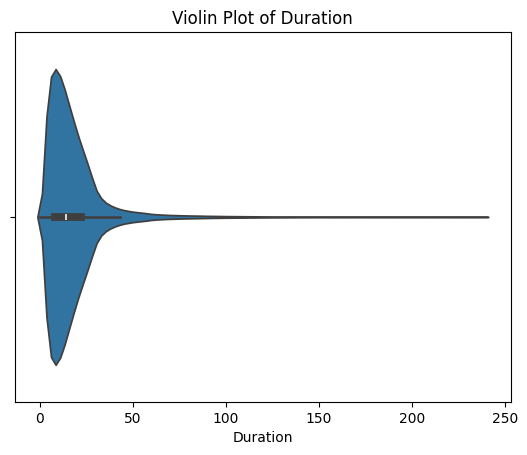

In [40]:
# Create a violin plot for the 'duration' column
sns.violinplot(x=df_filtered['duration'])

# Title and labels
plt.title('Violin Plot of Duration')
plt.xlabel('Duration')

# Show the plot
plt.show()

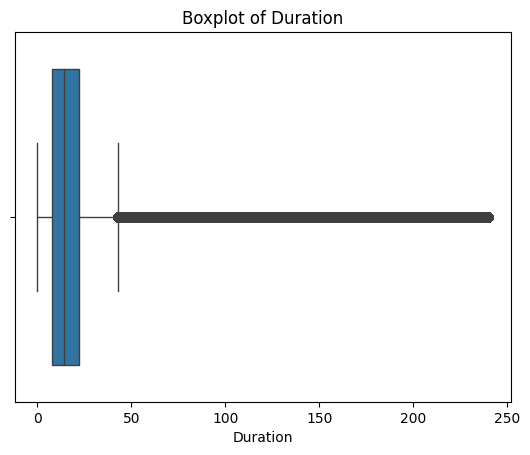

In [41]:
# Boxplot for duration
sns.boxplot(x=df_filtered['duration'])

plt.title('Boxplot of Duration')
plt.xlabel('Duration')

# Show the plot
plt.show()

**Insight**:  
- Even after applying a threshhold the data is still heavily skewed.  
- Necessary to apply the IQR Rule.

In [42]:
Q1 = df_filtered['duration'].quantile(0.25)
Q3 = df_filtered['duration'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_refined = df_filtered[(df_filtered['duration'] >= lower_bound) & (df_filtered['duration'] <= upper_bound)]

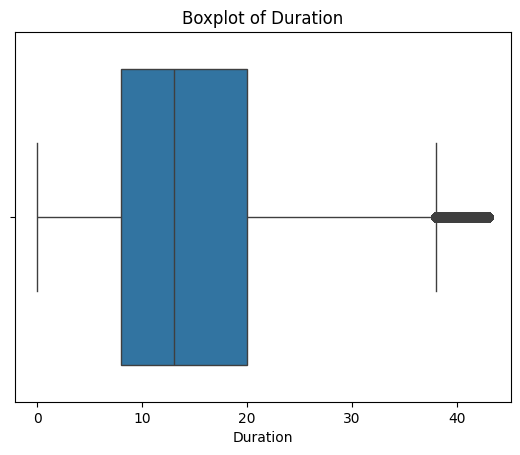

In [43]:
# Boxplot for duration
sns.boxplot(x=df_refined['duration'])

plt.title('Boxplot of Duration')
plt.xlabel('Duration')

# Show the plot
plt.show()

---

## **Add Features**

In [44]:
# Add time of the day a bike was used
df_refined['time_of_day'] = pd.to_datetime(df_refined['start_date']).dt.hour

/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_9704/258677265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_refined['time_of_day'] = pd.to_datetime(df_refined['start_date']).dt.hour


In [45]:
# Add day of weeke bike was used
df_refined['day_of_week'] = df_refined['start_date'].dt.day_name()

/var/folders/xk/r3ls7bqd0b3fdrwsj9bcv3t40000gn/T/ipykernel_9704/2406961076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_refined['day_of_week'] = df_refined['start_date'].dt.day_name()


In [46]:
# Number of unique stations
unique_stations = df_refined.start_station_name.nunique()
print(f"There are {unique_stations} unique stations in the dataset")

There are 829 unique stations in the dataset


In [47]:
# Net flows
station_usage = df_refined.groupby('start_station_name').size() - df_refined.groupby('end_station_name').size()

---

## **Rental Trends Over Time**

### **Daily Trends**

<Axes: title={'center': 'Daily Rental Trends'}, xlabel='start_date'>

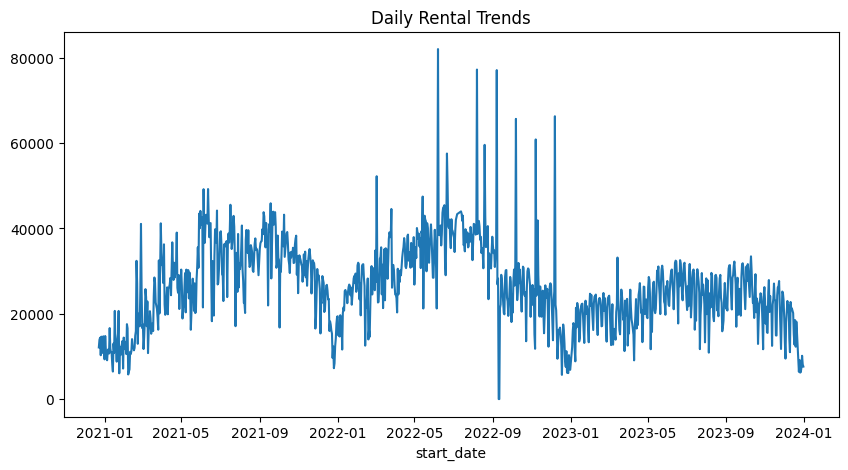

In [48]:
df_refined['start_date'].dt.date.value_counts().sort_index().plot(
    kind='line', figsize=(10,5), title="Daily Rental Trends")

**Insight**:  
- General trend follows the seasons (usage is lower in winter months around Jan and picks up moving into European summer around June).  
- Some spikes are noticeable between Jun-22 and Dec-23. Unclear what these could be (maybe other modes of transport were not working at those times?).
- Overall appears to be somewhat stable usage y-o-y from 2021 to 2022 (excluding 2022 spikes).  
- However, 2023 appears to have declined. Why? Is this anticipated to continue?

### **Trend by Month**

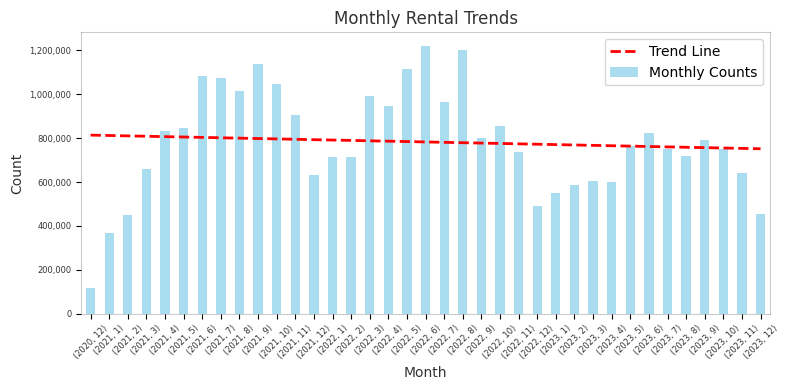

In [49]:
# Group by year and month
monthly_trend = df_refined.groupby([df_refined['start_date'].dt.year, df_refined['start_date'].dt.month]).size()

# Numeric index for plotting
x = np.arange(len(monthly_trend))
y = monthly_trend.values

# Uses np.polyfit to fit a linear regression line
trend = np.poly1d(np.polyfit(x, y, deg=1))

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot bar chart
monthly_trend.plot(kind="bar", ax=ax, color="skyblue", alpha=0.7, label="Monthly Counts")

# Plot trend line
ax.plot(x, trend(x), color="red", linestyle="--", linewidth=2, label="Trend Line")

# Title and labels
plt.title('Monthly Rental Trends', alpha=0.8)
plt.xlabel('Month', alpha=0.8)
plt.ylabel('Count', alpha=0.8)

# Format y-axis with thousands separator
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# X-axis formatting
plt.xticks(rotation=45, alpha=0.8)
plt.tick_params(axis='x', labelsize=6)

# Y-axis formatting
plt.yticks(alpha=0.8)
plt.tick_params(axis='y', labelsize=6)

# Adjust spine visibility
for spine in ax.spines.values():
    spine.set_alpha(0.2)

plt.legend()
plt.tight_layout()
plt.show()

**Insight**:  
- Declining trend in usage over time.

---

## **Trip Duration Analysis**

<Axes: ylabel='Frequency'>

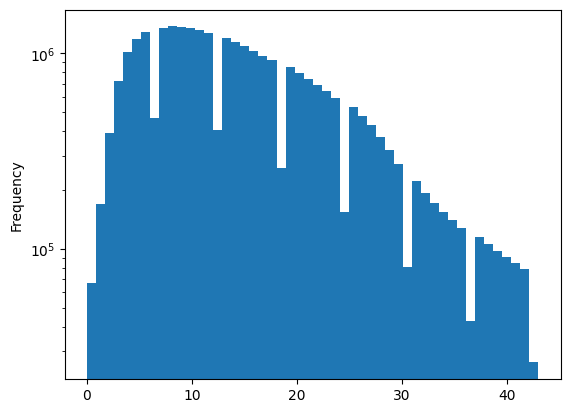

In [50]:
# Assess distribution of durations
# Log scale for visibility
df_refined['duration'].plot(kind='hist', bins=50, logy=True)

**Insight**:  
- Frequency peaks around 10 minutes.

---

## **Busiest Days & Hours**

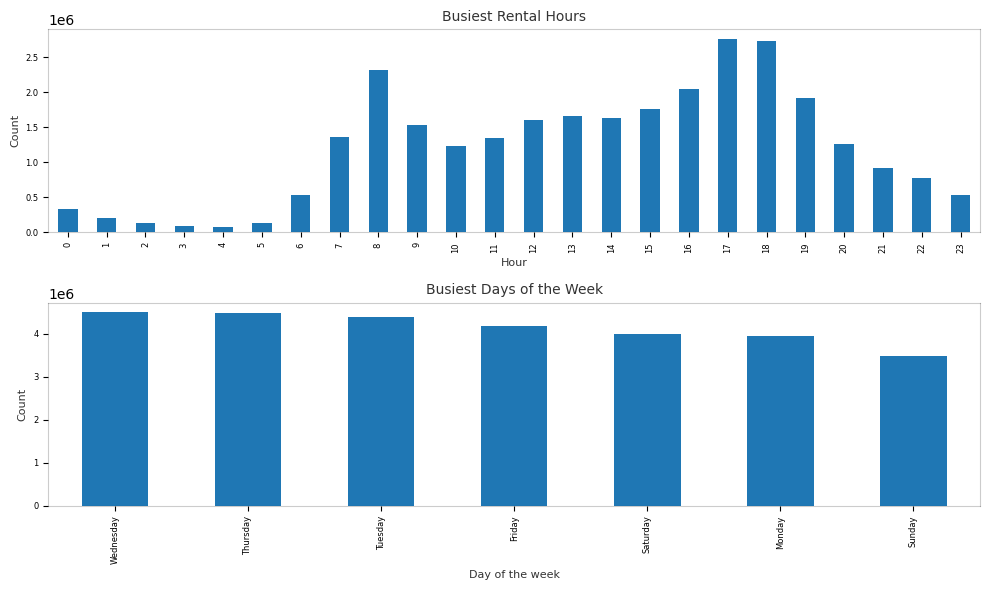

In [51]:
fig,ax = plt.subplots(2,1,figsize=(10,6))


df_refined['time_of_day'].value_counts().sort_index().plot(kind='bar', ax=ax[0])
df_refined['day_of_week'].value_counts().plot(kind='bar', ax=ax[1])

# Top 10 start stations
ax[0].set_title('Busiest Rental Hours', alpha=0.8, fontsize=10)
ax[0].set_ylabel('Count', alpha=0.8, fontsize=8)
ax[0].set_xlabel('Hour', alpha=0.8, fontsize=8)
ax[0].tick_params(axis='x', labelsize=6)
ax[0].tick_params(axis='y', labelsize=6)
for spine in ax[0].spines.values():
    spine.set_alpha(0.2)

# Top  10 end stations
ax[1].set_title('Busiest Days of the Week', alpha=0.8, fontsize=10)
ax[1].set_ylabel('Count', alpha=0.8, fontsize=8)
ax[1].set_xlabel('Day of the week', alpha=0.8, fontsize=8)
ax[1].tick_params(axis='x', labelsize=6)
ax[1].tick_params(axis='y', labelsize=6)
for spine in ax[1].spines.values():
    spine.set_alpha(0.2)

plt.tight_layout()
plt.show()

**Insight**:  
- 8am and 5/6pm appear to be the busiest times of the day.  
- Mondays and weekends are generally less busy.  
- Midweek is the busiest time (is that due to people working at home on Monday & Friday potentially?).  

---

## **Most popular stations**

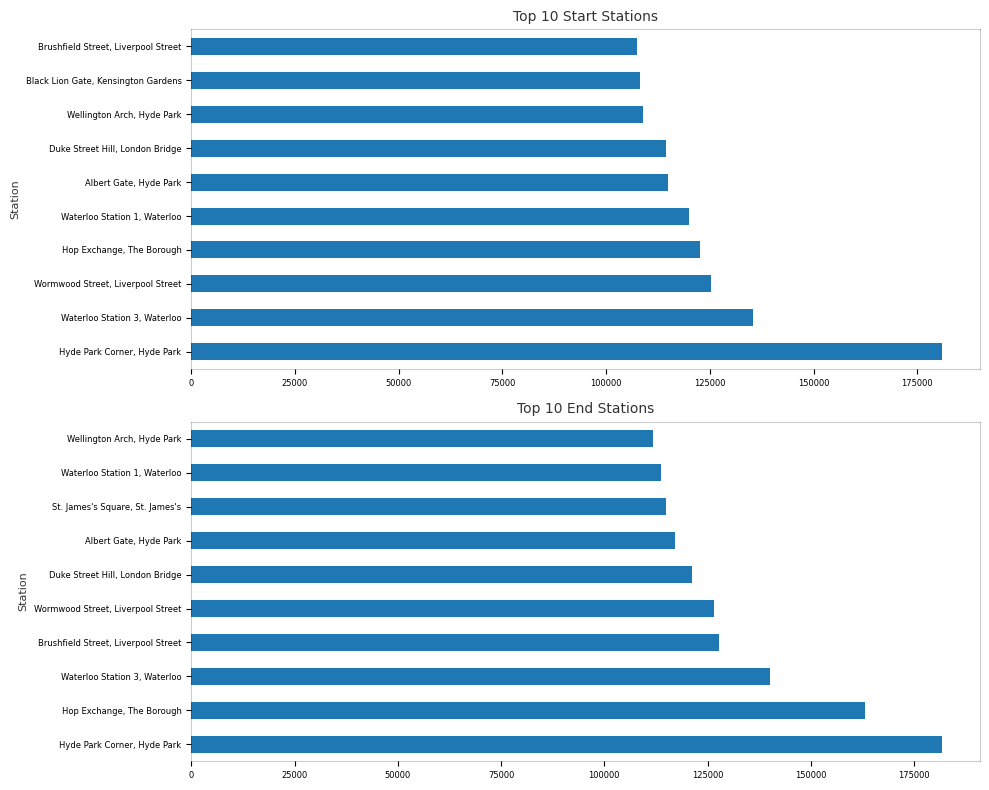

In [52]:
fig,ax = plt.subplots(2,1,figsize=(10,8))

df_refined['start_station_name'].value_counts().head(10).plot(kind='barh', ax=ax[0])
df_refined['end_station_name'].value_counts().head(10).plot(kind='barh', ax=ax[1])

# Top 10 start stations
ax[0].set_title('Top 10 Start Stations', alpha=0.8, fontsize=10)
ax[0].set_ylabel('Station', alpha=0.8, fontsize=8)
ax[0].tick_params(axis='x', labelsize=6)
ax[0].tick_params(axis='y', labelsize=6)
for spine in ax[0].spines.values():
    spine.set_alpha(0.2)

# Top  10 end stations
ax[1].set_title('Top 10 End Stations', alpha=0.8, fontsize=10)
ax[1].set_ylabel('Station', alpha=0.8, fontsize=8)
ax[1].tick_params(axis='x', labelsize=6)
ax[1].tick_params(axis='y', labelsize=6)
for spine in ax[1].spines.values():
    spine.set_alpha(0.2)

plt.tight_layout()
plt.show()

**Insight**: Hyde Park appears to be a central station where net inflows is close to zero.

---

## **Bike usage patterns**

- Compare the net flow of bikes between the morning and evening at each station to identify patterns of inflows and outflows at different times of day.  
- We would expect to see a larger % of people using bikes in the morning for commuting.  

In [53]:
# Isolate trips taken during the week -> filter out weekends
weekday_filter = df_refined[df_refined['start_date'].dt.day_of_week < 5]

In [54]:
# Organise data between weekday trips in the morning and those in the evening

# Weekday mornings (between 7am and 9am)
weekday_morning = weekday_filter[(weekday_filter['time_of_day'] >= 7) & (weekday_filter['time_of_day'] <= 9)]

# Weekday evenings (between 5pm and 7pm)
weekday_evening = weekday_filter[(weekday_filter['time_of_day'] >= 17) & (weekday_filter['time_of_day'] <= 19)]

In [55]:
# Calculate net flows by station during week in the morning & evening
# start_station_name.size(): Counts how many bikes left the station (outflows)
# end_station_name.size(): Counts how many bikes returned to the station (inflows)

weekday_morning_station_usage = weekday_morning.groupby('start_station_name').size() - weekday_morning.groupby('end_station_name').size()
weekday_evening_station_usage = weekday_evening.groupby('start_station_name').size() - weekday_evening.groupby('end_station_name').size()

**Note**:  
- If the result is positive, it indicates that more bikes were taken out than returned (more outflows).  
- If the result is negative, it indicates more bikes were returned than taken out (more inflows).  

In [56]:
weekday_morning_station_usage = weekday_morning_station_usage.to_frame().reset_index()
weekday_evening_station_usage = weekday_evening_station_usage.to_frame().reset_index()

In [57]:
weekday_morning_station_usage.rename(columns={"index": 'station', 0: 'net_flow_morning'}, inplace=True)
weekday_evening_station_usage.rename(columns={"start_station_name": 'station', 0: 'net_flow_evening'}, inplace=True)

In [58]:
# We are interested in stations that appear in both datasets to assess differences in net flows based on time of day
weekday_morning_evening_merged = weekday_morning_station_usage.merge(right=weekday_evening_station_usage, on='station', how='inner')
weekday_morning_evening_merged.head()

,station,net_flow_morning,net_flow_evening
0,"Abbey Orchard Street, Westminster",-13837.0,8407
1,"Abbotsbury Road, Holland Park",853.0,-117
2,"Aberdeen Place, St. John's Wood",3202.0,-1455
3,"Aberfeldy Street, Poplar",823.0,-558
4,"Abingdon Green, Westminster",-9296.0,5738


In [59]:
# Create a new column to show the net flow between morning and evening
weekday_morning_evening_merged['flow_difference'] = weekday_morning_evening_merged['net_flow_morning'] - weekday_morning_evening_merged['net_flow_evening']
weekday_morning_evening_merged.head()

,station,net_flow_morning,net_flow_evening,flow_difference
0,"Abbey Orchard Street, Westminster",-13837.0,8407,-22244.0
1,"Abbotsbury Road, Holland Park",853.0,-117,970.0
2,"Aberdeen Place, St. John's Wood",3202.0,-1455,4657.0
3,"Aberfeldy Street, Poplar",823.0,-558,1381.0
4,"Abingdon Green, Westminster",-9296.0,5738,-15034.0


In [60]:
# Top 10 stations for outflows
weekday_morning_top10 = weekday_morning_evening_merged.sort_values(by="flow_difference", ascending=False).head(10)

# Top 10 stations for inflows
weekday_evening_top10 = weekday_morning_evening_merged.sort_values(by="flow_difference", ascending=True).head(10)

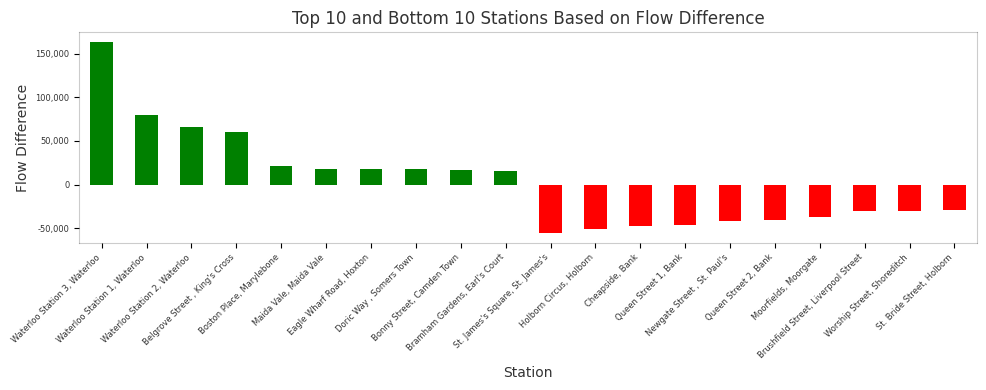

In [61]:
# Select top 10 and bottom 10 stations
top_10_stations = weekday_morning_evening_merged.sort_values(by='flow_difference', ascending=False).head(10)
bottom_10_stations = weekday_morning_evening_merged.sort_values(by='flow_difference', ascending=True).head(10)

# Combine top and bottom stations for comparison
combined_stations = pd.concat([top_10_stations, bottom_10_stations])

fig, ax = plt.subplots(figsize=(10, 4))

# Plot bar chart
combined_stations.plot(kind='bar', x='station', y='flow_difference', color=['green']*10 + ['red']*10, legend=False, ax=ax)

plt.title('Top 10 and Bottom 10 Stations Based on Flow Difference', fontsize=12, alpha=0.8)
plt.xlabel('Station', alpha=0.8)
plt.ylabel('Flow Difference', alpha=0.8)
plt.xticks(rotation=45, ha='right', alpha=0.8)
plt.tick_params(axis='x', labelsize=6)
plt.yticks(alpha=0.8)
plt.tick_params(axis='y', labelsize=6)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))
for spine in plt.gca().spines.values():
    spine.set_alpha(0.2)
plt.grid(False)
plt.tight_layout()

# Show plot
plt.show()

---

## **Station imbalances**

<Axes: title={'center': 'Station Demand vs. Supply'}>

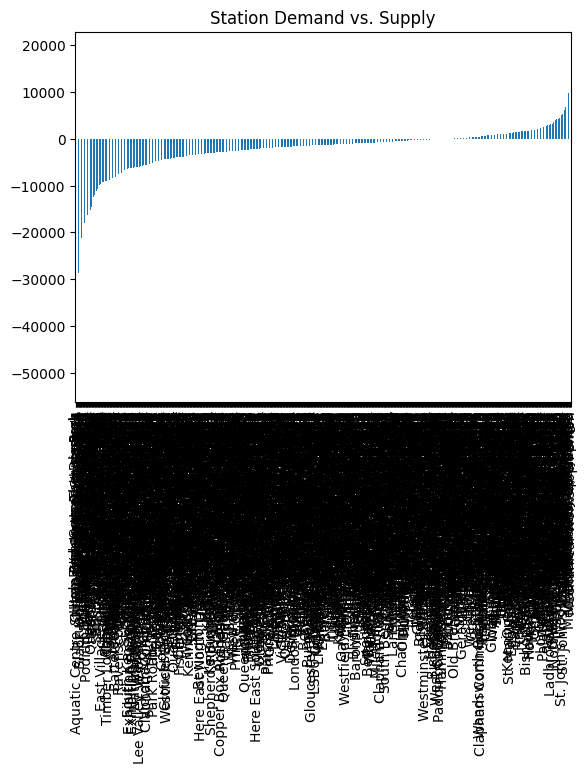

In [62]:
station_usage = df_refined.groupby('start_station_name').size() - df_combined.groupby('end_station_name').size()
station_usage.sort_values().plot(kind='bar', title="Station Demand vs. Supply")

**Insight**:  
- This chart is not particularly useful but serves to show that stations on either end have demand vs supply imbalances.
- How does this impact supply chain considerations?  

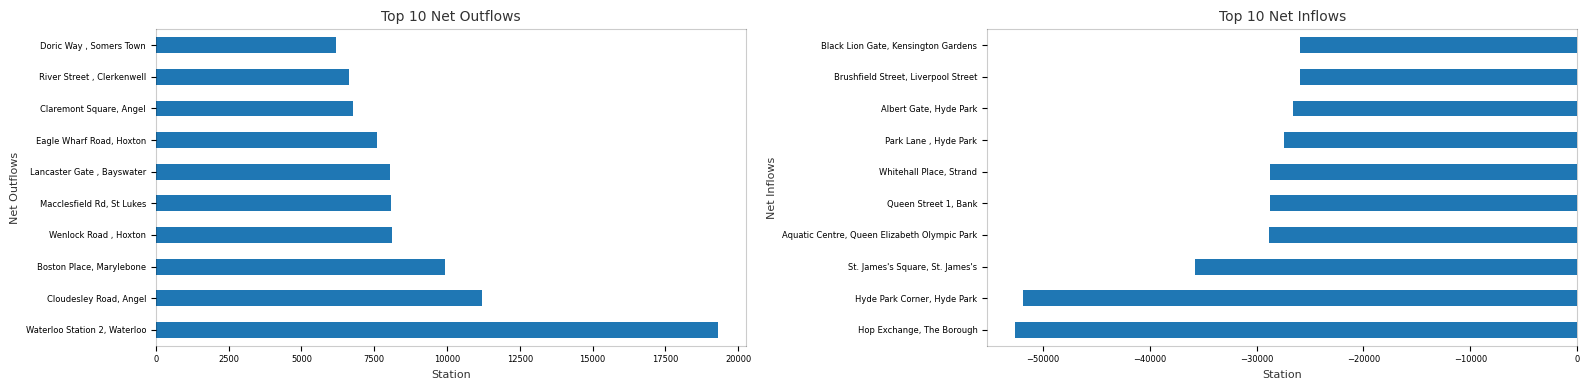

In [63]:
# Visualise demand vs supply imbalances

fig, ax = plt.subplots(1,2, figsize=(16,4))

top_10_net_outflow = station_usage.sort_values(ascending=False)[:10]
top_10_net_inflow = station_usage.sort_values(ascending=True)[:10]

top_10_net_outflow.plot(kind='barh',ax=ax[0])
top_10_net_inflow.plot(kind='barh',ax=ax[1])

# Net outflows
ax[0].set_title('Top 10 Net Outflows', alpha=0.8, fontsize=10)
ax[0].set_xlabel('Station', alpha=0.8, fontsize=8)
ax[0].set_ylabel('Net Outflows', alpha=0.8, fontsize=8)
ax[0].tick_params(axis='x', labelsize=6)
ax[0].tick_params(axis='y', labelsize=6)
for spine in ax[0].spines.values():
    spine.set_alpha(0.2)

# Net inflows
ax[1].set_title('Top 10 Net Inflows', alpha=0.8, fontsize=10)
ax[1].set_xlabel('Station', alpha=0.8, fontsize=8)
ax[1].set_ylabel('Net Inflows', alpha=0.8, fontsize=8)
ax[1].tick_params(axis='x', labelsize=6)
ax[1].tick_params(axis='y', labelsize=6)
for spine in ax[1].spines.values():
    spine.set_alpha(0.2)

plt.tight_layout()
plt.show()

**Insight**: Possible reasons for differences noted in the the count of trips starting at a station minus the count of trips ending at that station is.  

Positive difference: More trips start here than end here. This station is a bike source (bikes are frequently taken but not returned as often).  
Possible reasons:  
- Located in residential areas (people start trips here to commute elsewhere).  
- Near transit hubs (people rent bikes to get to work or school).  
- Could experience bike shortages if not replenished.  

Negative: More trips end here than start here. This station is a bike sink (bikes are frequently dropped off but not taken as often).  
Possible reasons:  
- Located in office districts, universities, or shopping areas (people ride here but don’t start trips as frequently).  
- Could experience bike congestion, requiring redistribution.  

---

## **Create categories of users**

**Rationale**:
- Bucket users into new categories based on the length of time they use a bike for.  
- This will help us understand the profile of potential customers.  

In [64]:
def categorise_trip(duration):
    if duration < 10:
        return "quick_errand"
    elif duration < 30:
        return "commute"
    elif duration < 60:
        return "leisure_ride"
    else:
        return "long_trip" # tourism?

df_combined['trip_category'] = df_combined['duration'].apply(categorise_trip)

In [65]:
df_combined.trip_category.value_counts(normalize=True)

trip_category
commute         0.562019
quick_errand    0.313473
leisure_ride    0.090367
long_trip       0.034141
Name: proportion, dtype: float64

In [66]:
fig = plt.figure(figsize=(12,6))

category_day_count = df_combined.groupby(['trip_category', 'day_of_week']).size().sort_values(ascending=False).unstack(fill_value=0)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot bar chart
category_day_count.plot(kind='bar', ax=ax, stacked=True, colormap='Blues')

# Customize the plot
plt.title('Trip Categories Over the Week', alpha=0.8)
plt.xlabel('Trip Category', alpha=0.8)
plt.ylabel('Count', alpha=0.8)
plt.xticks(rotation=45, alpha=0.8)
plt.tick_params(axis='x', labelsize=6)
plt.yticks(alpha=0.8)
plt.tick_params(axis='y', labelsize=6)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))
for spine in plt.gca().spines.values():
    spine.set_alpha(0.2)
plt.tight_layout()
plt.show()

KeyError: 'day_of_week'

<Figure size 1200x600 with 0 Axes>

**Insight**:  
- Commutes & quick errands comprise a significant share of the trips.  
- Within a category (i.e. commute) the number of trips is largely consistent across the week.

In [ ]:
df_combined.groupby(['trip_category', 'day_of_week']).size().sort_values(ascending=False)['commute']

day_of_week
Wednesday    2692143
Thursday     2683737
Tuesday      2625428
Friday       2454801
Saturday     2450874
Monday       2328352
Sunday       2125084
dtype: int64

In [ ]:
df_counts = df_combined.groupby(['trip_category', 'day_of_week']).size()

df_percentage = df_counts.groupby(level=1).apply(lambda x: (x / x.sum()) * 100)

print(df_percentage)

day_of_week  trip_category  day_of_week
Friday       commute        Friday         55.497200
             leisure_ride   Friday          8.312120
             long_trip      Friday          3.065774
             quick_errand   Friday         33.124906
Monday       commute        Monday         55.954693
             leisure_ride   Monday          8.021724
             long_trip      Monday          2.890964
             quick_errand   Monday         33.132619
Saturday     commute        Saturday       55.153270
             leisure_ride   Saturday       12.655187
             long_trip      Saturday        5.532668
             quick_errand   Saturday       26.658874
Sunday       commute        Sunday         54.761780
             leisure_ride   Sunday         12.644549
             long_trip      Sunday          6.011034
             quick_errand   Sunday         26.582637
Thursday     commute        Thursday       57.240674
             leisure_ride   Thursday        7.496640
      

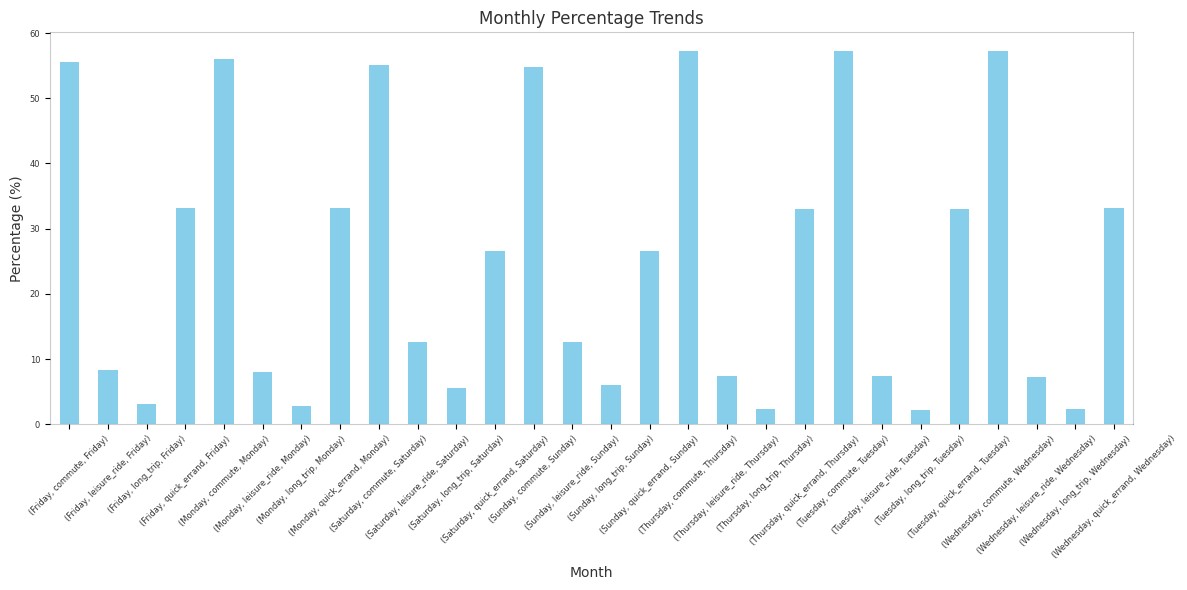

In [72]:
# Plot percentage data
fig, ax = plt.subplots(figsize=(12, 6))

df_percentage.plot(kind='bar', ax=ax, color='skyblue')

# Title and labels
plt.title('Monthly Percentage Trends', alpha=0.8)
plt.xlabel('Month', alpha=0.8)
plt.ylabel('Percentage (%)', alpha=0.8)

# Formatting x and y axes
plt.xticks(rotation=45, alpha=0.8)
plt.tick_params(axis='x', labelsize=6)
plt.yticks(alpha=0.8)
plt.tick_params(axis='y', labelsize=6)

# Adjust spine visibility
for spine in ax.spines.values():
    spine.set_alpha(0.2)

plt.tight_layout()
plt.show()

---

## **Data Science use cases**

1. **Demand Prediction**:  
- Predicting rental demand at different times of day, days of the week, and by station to understand when and where demand will be highest, assisting in supply chain and operational planning.  

2. **Customer Segmentation**:  
- Analysing user behavior based on trip duration, frequency, or station usage to identify customer segments.  

3. **Supply Chain Optimisation**:  
- Predictive model to optimise the supply of bikes across different stations based on bike usage patterns and demand analysis (morning vs evening flows).  

4. **Bike Maintenance Prediction & Fleet Management**:  
- Identify frequent problems (e.g., bikes used for long durations vs. quick trips) by analysing usage patterns to predict when bikes will need maintenance.  

5. **Anomaly Detection**:  
- Detecting unusual cycling patterns or anomalies (such as very long trip durations) could help improve operational efficiency and ensure the service is functioning as expected.  

---

## **Demand Forecasting**

Build a simple regression model to predict bike demand at each station at different times based on:  
- Create a demand target variable.  
- Number of rentals (rows) that occurred at each station and time period will be the proxy for demand.  
- Group by <code>start_station_name</code>, <code>time_of_day</code>, and <code>day_of_week</code> to get the total number of rentals for those features.  

**Possible features**:  
- Time of day;  
- Day of the week;  
- Duration; and
- Station (start and end).

In [67]:
# Group by start station, time of day, and day of week to calculate demand
df_demand = df_refined.groupby(['start_station_name', 'time_of_day', 'day_of_week']).size().reset_index(name='demand')

# Merge the demand column back into the main dataframe based on the corresponding columns
df_refined = pd.merge(df_refined, df_demand, on=['start_station_name', 'time_of_day', 'day_of_week'], how='left')

df_refined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name,start_station_id,end_station_id,time_of_day,day_of_week,demand
0,104708347,40.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames",2,306,13,Sunday,526
1,104664061,5.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo",3,372,15,Thursday,445
2,104723992,24.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park",4,5,13,Monday,1375
3,104721666,14.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove",5,435,11,Monday,212
4,104723631,14.0,17175,2020-12-28 13:05:00,"Albert Gate, Hyde Park",2020-12-28 12:51:00,"Pall Mall East, West End",6,4,12,Monday,267


---

## **Create round trip feature**

In [68]:
# Create a round_trip column
# 1 if start and end station are the same, 0 otherwise
df_refined['round_trip'] = (df_refined['start_station_name'] == df_refined['end_station_name']).astype(int)

# Calculate the number of total trips, round trips, one way trips
total_trips = len(df_refined)
count_of_round_trips = len(df_refined[df_refined.round_trip == 1])
count_of_one_way_trips = len(df_refined[df_refined.round_trip == 0])

# Calcualte the percentage of round trips and one way trips
percent_round_trips = count_of_round_trips / total_trips * 100
percent_one_way_trips = count_of_one_way_trips / total_trips *100

print(f"{percent_round_trips:.2f}% of trips are round trips")
print(f"{percent_one_way_trips:.2f}% of trips are one way")

3.26% of trips are round trips
96.74% of trips are one way


---

## **Create new column for day of week**

In [69]:
df_refined['day_of_week_int'] = df_refined['start_date'].dt.dayofweek

## **Feature Engineering**

Encode start and end locations:  
- One-hot encoding will create a column for each of the 861 unique stations. This is not efficient.  
- Label encoding may introduce ordinal relationships that aren’t actually present.  
- Frequency encoding: Encode stations based on their frequency of appearance. More popular stations (with higher rental counts) get a higher value, less popular stations get a lower value.  

In [70]:
# Frequency encoding for start_station and end_station
station_counts = df_refined['start_station_name'].value_counts()
df_refined["start_station_encoded"] = df_refined["start_station_name"].map(station_counts)

# Frequency encoding for end_station
end_station_counts = df_refined['end_station_name'].value_counts()
df_refined['end_station_encoded'] = df_refined['end_station_name'].map(end_station_counts)

df_refined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name,start_station_id,end_station_id,time_of_day,day_of_week,demand,round_trip,day_of_week_int,start_station_encoded,end_station_encoded
0,104708347,40.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames",2,306,13,Sunday,526,0,6,49762,163159
1,104664061,5.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo",3,372,15,Thursday,445,0,3,73450,33551
2,104723992,24.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park",4,5,13,Monday,1375,0,0,114894,28070
3,104721666,14.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove",5,435,11,Monday,212,0,0,28295,107888
4,104723631,14.0,17175,2020-12-28 13:05:00,"Albert Gate, Hyde Park",2020-12-28 12:51:00,"Pall Mall East, West End",6,4,12,Monday,267,0,0,51414,117222


**Insight**:  
- <code>start_station_encoded</code> will be used as a proxy for demand (bike pick up points), while <code>end_station_encoded</code> speaks to supply (bike drop off points).  
- Both are important, but for the intial model we will only use <code>start_station_encoded</code>.  

---

## **Sampling**

Stratifying based on the day of the week to account for cyclical patterns over the course of the week.  

In [71]:
df_refined.head()

,rental_id,duration,bike_id,end_date,end_station_name,start_date,start_station_name,start_station_id,end_station_id,time_of_day,day_of_week,demand,round_trip,day_of_week_int,start_station_encoded,end_station_encoded
0,104708347,40.0,12134,2020-12-27 14:37:00,"Hop Exchange, The Borough",2020-12-27 13:57:00,"Curlew Street, Shad Thames",2,306,13,Sunday,526,0,6,49762,163159
1,104664061,5.0,18429,2020-12-24 15:23:00,"Walnut Tree Walk, Vauxhall",2020-12-24 15:18:00,"Baylis Road, Waterloo",3,372,15,Thursday,445,0,3,73450,33551
2,104723992,24.0,17175,2020-12-28 13:30:00,"Blenheim Crescent, Ladbroke Grove",2020-12-28 13:06:00,"Albert Gate, Hyde Park",4,5,13,Monday,1375,0,0,114894,28070
3,104721666,14.0,15313,2020-12-28 11:23:00,"Black Lion Gate, Kensington Gardens",2020-12-28 11:09:00,"Blenheim Crescent, Ladbroke Grove",5,435,11,Monday,212,0,0,28295,107888
4,104723631,14.0,17175,2020-12-28 13:05:00,"Albert Gate, Hyde Park",2020-12-28 12:51:00,"Pall Mall East, West End",6,4,12,Monday,267,0,0,51414,117222


In [92]:
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit with 3 splits and a test size of 20%
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# Features and target variables
features = ['start_station_encoded', 'time_of_day', 'day_of_week_int']
X = df_refined[features]
y = df_refined['demand']

# Maintain the same proportion of day_of_week_int in both training and testing sets.
for train_index, test_index in sss.split(X, df_refined['day_of_week_int']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

---

## **Train Model**

### **Linear Regression**

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
lr_model = LinearRegression()

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Output the evaluation metrics
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 330143.081395179
Root Mean Squared Error: 574.5807875270274
R-squared: 0.3069997009543436


In [79]:
# Cross the model using cross validation

from sklearn.model_selection import cross_val_score

# Perform cross-validation (using negative mean squared error because cross_val_score minimizes loss)
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive and calculate RMSE
mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)

# Print results
print(f'MSE Scores: {mse_scores}')
print(f'RMSE Scores: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')

MSE Scores: [324479.33638742 329201.4613621  329957.49785041 325750.82133724
 329051.19531307]
RMSE Scores: [569.63087731 573.76080501 574.41927009 570.74584654 573.62984172]
Average RMSE: 572.4373281330315


In [107]:
import pandas as pd

# Ensure encoding and names are extracted from the same DataFrame
station_data = df_refined[['start_station_name', 'start_station_encoded']].drop_duplicates()

# Create a prediction DataFrame
df_prediction = pd.DataFrame({
    'start_station_encoded': station_data['start_station_encoded'],
    'start_station_name': station_data['start_station_name'],
    'time_of_day': ['08:00'] * len(station_data),
    'day_of_week_int': [2] * len(station_data)
})

# Convert 'time_of_day' to a numeric format (hours)
df_prediction['time_of_day'] = pd.to_datetime(df_prediction['time_of_day'], format='%H:%M').dt.hour  

# Ensure feature order matches training data
X_predict = df_prediction[['start_station_encoded', 'time_of_day', 'day_of_week_int']]

# Convert X_predict to a DataFrame with correct column names
X_predict = pd.DataFrame(X_predict, columns=features)

# Predict demand using the trained model
df_prediction['predicted_demand'] = lr_model.predict(X_predict)

# Sort and display top stations
df_sorted = df_prediction.sort_values(by='predicted_demand', ascending=False)
top_stations = df_sorted.head(10)
print(top_stations[['start_station_name', 'predicted_demand']])

                        start_station_name  predicted_demand
951            Hyde Park Corner, Hyde Park       2491.664439
669           Waterloo Station 3, Waterloo       1839.616133
287      Wormwood Street, Liverpool Street       1693.803824
995              Hop Exchange, The Borough       1655.790053
2388          Waterloo Station 1, Waterloo       1619.376261
2                   Albert Gate, Hyde Park       1546.291537
14968      Duke Street Hill, London Bridge       1540.834468
616             Wellington Arch, Hyde Park       1459.278431
1905   Black Lion Gate, Kensington Gardens       1451.235682
2082   Brushfield Street, Liverpool Street       1439.907264


### **Random Forest**

In [ ]:
# Use GridSearchCV to find best hyperparameters for the Random Forest model

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Set up GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print(grid_search.best_params_)

# Evaluate on the test set
# R^2 score for regression models
print(grid_search.score(X_test, y_test))

KeyboardInterrupt: 

### **Gradient Boosting Regressor**

In [80]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the Gradient Boosting model
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Perform cross-validation
mse_scores = -cross_val_score(gb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Compute RMSE
rmse_scores = np.sqrt(mse_scores)

# Output results
print("MSE Scores:", mse_scores)
print("RMSE Scores:", rmse_scores)
print("Average RMSE:", np.mean(rmse_scores))

KeyboardInterrupt: 

In [ ]:
# Fit the model
gb.fit(X_train, y_train)

# Get feature importances
importances = gb.feature_importances_

# Display feature importances
feature_importance_dict = dict(zip(X_train.columns, importances))
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

### **SGD Regressor**

In [82]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Standardize features (SGD is sensitive to feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train SGDRegressor
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train_scaled, y_train)

# Cross-validation scores
cv_scores = cross_val_score(sgd_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Evaluate the model
y_pred = sgd_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Output results
print(f"Cross-Validation MSE Scores: {-cv_scores}")
print(f"Mean CV MSE: {-cv_scores.mean()}")
print(f"Test RMSE: {rmse}")
print(f"Test R²: {r2}")

KeyboardInterrupt: 

#### **Train on subset of data**

In [83]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Take a 10% random sample of the dataset
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# Initialize and train the SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X_sample, y_sample)

# Evaluate the model on the full test set
y_pred = sgd_reg.predict(X_test)

# Compute evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1.1823432085803047e+32
Root Mean Squared Error: 1.087356063385083e+16
R-squared: -2.4818457308211128e+26
